# Effects of background conductivity on IP signals

**Author**: [Seogi Kang](https://github.com/sgkang)

This notebooks investigate a question: "How does the background conductivity affect the IP signals" by simulating AEM signals with variable background conductivity values. 
This notebook was used to produce Figures 5, 6 in Kang et al. (2019). 

In [10]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e, Rx, Survey
%matplotlib inline

In [11]:
figdir = "./figures/"

## Step1: Fix the conductivity of the halfspace($\sigma_{half}$), but vary the conductivity of the target ($\sigma_{\infty}$)

In [12]:
# Locations of the receiver and source loops
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])

In [14]:
cs, ncx, ncz, npad = 10., 10, 40, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_2s = [0.0001, 0.001, 0.01, 0.1, 1.]
sig_1 = 0.001
data_list = []
data_em_list = []
data_ip_list = []
for sig_2 in sig_2s:    
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list.append(data) 
    
    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
#     prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em = survey_em.dpred(m)
    data_em_list.append(data_em) 
    data_ip_list.append(data - data_em)

0.1 0.001 0.7


/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)
/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7


### Step 2-1: Plot decay curves

In [15]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
import matplotlib 
matplotlib.rcParams["font.size"] = 16
moment = np.pi*src_emip.radius**2 / 1e12
area = np.pi*(13**2)
noise_floor = 1e-4

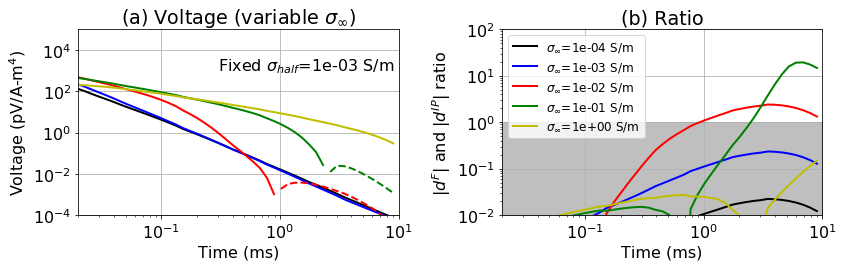

In [28]:
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$\sigma_{\infty}$=%.0e S/m")%(sig_2) for sig_2 in sig_2s]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey']
for i in range(5):
    data_p, data_n = get_dobs_pn(data_list[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)

for i in range(5):
    data_p, data_n = get_dobs_pn(data_list[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(5):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list[i].flatten()/data_em_list[i].flatten()), linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=12)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage (pV/A-m$^4$)")    
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-2, 1e2)
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')
ax.set_title("(a) Voltage (variable $\sigma_{\infty}$)")
ax1.set_title("(b) Ratio")
ax.text(0.3, 1e3, ("Fixed $\sigma_{half}$=%.0e S/m")%(1e-3))
tmin, tmax = 2e-5*ms, 0.01*ms
ax.fill_between([tmin, tmax], np.r_[noise_floor, noise_floor], y2=np.r_[1e-8, 1e-8], color='grey', alpha=0.5)
ax1.fill_between([tmin, tmax], np.r_[1e0, 1e0], y2=np.r_[1e-2, 1e-2], color='grey', alpha=0.5)
plt.tight_layout()    
fig.savefig(figdir+"data_background_1", dpi=300)

## Step3: Fix the ratio of $\sigma_{half}/ \sigma_{\infty}$, but vary the conductivity of the halfspace ($\sigma_{half}$)

In [17]:
cs, ncx, ncz, npad = 25., 25, 40, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_1s = [1./10000, 1./1000, 1./100, 1./50, 1./10.]

data_list_siginf = []
data_em_list_siginf = []
data_ip_list_siginf = []
for sig_1 in sig_1s:
    sig_2 = sig_1*10.
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_siginf.append(data) 
    
    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
#     prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)    
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em = survey_em.dpred(m)
    data_em_list_siginf.append(data_em) 
    data_ip_list_siginf.append(data - data_em)

0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7


### Step 3-1: Plot decay curves

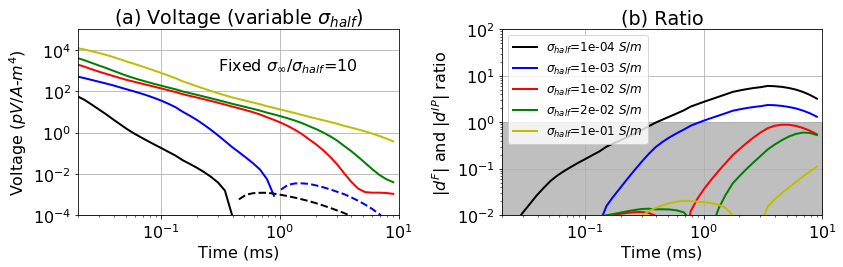

In [18]:
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$\sigma_{half}$=%.e $S/m$")%(sig_1) for sig_1 in sig_1s]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey']
for i in range(len(sig_1s)):
    data_p, data_n = get_dobs_pn(data_list_siginf[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)

for i in range(len(sig_1s)):
    data_p, data_n = get_dobs_pn(data_list_siginf[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(len(sig_1s)):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_siginf[i].flatten()/data_em_list_siginf[i].flatten()), linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=12)    

for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-2, 1e2)
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')
ax.set_title("(a) Voltage (variable $\sigma_{half}$)")
ax1.set_title("(b) Ratio")
ax.text(0.3, 1e3, "Fixed $\sigma_{\infty}/\sigma_{half}$=10")
tmin, tmax = 2e-5*ms, 0.01*ms
ax.fill_between([tmin, tmax], np.r_[noise_floor, noise_floor], y2=np.r_[1e-8, 1e-8], color='grey', alpha=0.5)
ax1.fill_between([tmin, tmax], np.r_[1e0, 1e0], y2=np.r_[1e-2, 1e-2], color='grey', alpha=0.5)

plt.tight_layout()    

fig.savefig(figdir+"data_background_2", dpi=300)